# Star Wars survey

---
## Motivation
The second [best sci-fi franchise](https://www.youtube.com/watch?v=lVIGhYMwRgs) has a lot of [die hard fans](https://www.businessinsider.com/biggest-star-wars-fans-2015-11?r=DE&IR=T), that take Star Wars [kind of serious](https://en.wikipedia.org/wiki/Jedi_census_phenomenon). 

But what goes on inside these people's heads?
+ Do they agree about the quality of the movies?
+ Do they actually have taste, i.e. adore Jar Jar?
+ Do some socio-demographic groups have diverging views compared to the average Star Wars fan? 

--- 
## Methodology
In 2014 FiveThirtyEight surveyed more than 1,100 individuals on their views about the franchise. The news website later published an [article](https://fivethirtyeight.com/features/americas-favorite-star-wars-movies-and-least-favorite-characters/) on the results and posted the [data](https://github.com/fivethirtyeight/data/tree/master/star-wars-survey) on their github-page.

The dataset includes:
+ sociodemographic information (for example age, income, education, gender)
+ information if a responded saw the first six movies and how they rated them
+ ratings of the most popular characters
+ additional fandom information (for example knowledge of the Extended Universe or if they consider themselves to be fans)

After we performed some initial cleaning, we will plot a few interesting observations.

---
## Results

+ **No love for the new trilogy** Episodes 4-6 are generally ranked higher than Episodes 1-3. But Non Star Wars fans rank the newer trilogy (Episode 1-3) higher than Star Wars fans do. For example: At least 75% of fans rank Episode 2 fourth or lower (median = fifth). 75% of non-fans rank Episode 2 as second best film or lower (median=fourth). <br> Star Wars fans appreciate Episode 4 much more (median =second) than non-fans (median=fourth). 
+ **The elderly like Jar Jar!** Fans really don't like poor Jar Jar (50% unfavorably - compared to 28% amongst non-fans). But we really found his key demographic, (60+years)! More people in this age-group like him than not (39% vs. 26%) - quite the opposite of [what George Lucas intended](https://www.quora.com/Why-did-George-Lucas-want-Jar-Jar-Binks-to-be-entertaining-to-kids).
+ **Han shot first** The majority of respondents who understood the question thought that Han shot first (319 of 510). The majority of non-fans did not understand the question (175 out of 274), but even a few self-proclaimed Star Wars fans did not understand the question (~70). Even more shocking: a few fans of the extended universe (EU) did not understand the question (9).
+ **Star Wars fans feel strongly or even like the villains.** Emperor Palpatine splits fans into likeing him or not (43% like him, 31% don't) - unlike with non-fans, who feel mostly neutral about him (53%). EU-fans even have a bigger heart for villains. They like Palpatine and Boba Fett (~60%) - compared to only ~35-40% of non-EU-fans.
---

# Loading data and initial inspection

In [1]:
import numpy as np
import pandas as pd # maybe use modin.pandas for huge datasets
import matplotlib.pyplot as plt
import missingno as msno # check for missing records
import warnings

# Standard plotly imports
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

# jupyter command to show plots in notebook
%matplotlib inline

# setting pandas display options
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 50)
#pd.set_option('display.max_rows', 20)
pd.set_option('max_colwidth', 50)

# # widgets
# import ipywidgets as widgets
# from ipywidgets import interact, interact_manual

In [2]:
# import dataset, respondent ID is not a meaningful integer, thus imported as string
star_wars = pd.read_csv("StarWars.csv", encoding="ISO-8859-1", dtype={"RespondentID": "str"})

# remove second header line
string = "remove {} record because RespondentID is nan - record is second header line"
print(string.format(star_wars["RespondentID"].isna().sum()))
sec_header = star_wars[star_wars["RespondentID"].isna()] # save for later use
star_wars = star_wars[star_wars["RespondentID"].notna()]

remove 1 record because RespondentID is nan - record is second header line


In [3]:
star_wars.shape
# the dataset has 1186 records and 38 features

(1186, 38)

In [4]:
# initial check of data
star_wars.describe()

,RespondentID,Have you seen any of the 6 films in the Star Wars franchise?,Do you consider yourself to be a fan of the Star Wars film franchise?,Which of the following Star Wars films have you seen? Please select all that apply.,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Please rank the Star Wars films in order of preference with 1 being your favorite film in the franchise and 6 being your least favorite film.,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,"Please state whether you view the following characters favorably, unfavorably, or are unfamiliar with him/her.",Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Which character shot first?,Are you familiar with the Expanded Universe?,Do you consider yourself to be a fan of the Expanded Universe?æ,Do you consider yourself to be a fan of the Star Trek franchise?,Gender,Age,Household Income,Education,Location (Census Region)
count,1186,1186,836,673,571,550,607,758,738,835,836,835,836,836,836,829,831,831,823,825,814,826,820,812,827,830,821,814,826,828,828,213,1068,1046,1046,858,1036,1043
unique,1186,2,2,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,3,2,2,2,2,4,5,5,9
top,3289282741,Yes,Yes,Star Wars: Episode I The Phantom Menace,Star Wars: Episode II Attack of the Clones,Star Wars: Episode III Revenge of the Sith,Star Wars: Episode IV A New Hope,Star Wars: Episode V The Empire Strikes Back,Star Wars: Episode VI Return of the Jedi,4,5,6,1,1,2,Very favorably,Very favorably,Very favorably,Somewhat favorably,Very favorably,Neither favorably nor unfavorably (neutral),Very favorably,Neither favorably nor unfavorably (neutral),Neither favorably nor unfavorably (neutral),Very favorably,Very favorably,Very unfavorably,Neither favorably nor unfavorably (neutral),Very favorably,Han,No,No,No,Female,45-60,"$50,000 - $99,999",Some college or Associate degree,East North Central
freq,1,936,552,673,571,550,607,758,738,237,300,217,204,289,232,610,552,547,269,591,213,310,236,248,474,562,204,207,605,325,615,114,641,549,291,298,328,181


Noticeable data cleanliness issues:
+ many column headers are not named properly
+ some columns (e.g. unnamed: 4) only have one unique value - they should possibly be formatted as booleans
+ binary variables ("Yes/No") are not formatted as booleans <br>

We will need to fix these things.

# Fixing values, column headers and missing data points

In [5]:
# format Yes / No to boolean
yn_cols = ["Have you seen any of the 6 films in the Star Wars franchise?",
           "Do you consider yourself to be a fan of the Star Wars film franchise?",
           "Are you familiar with the Expanded Universe?",
           "Do you consider yourself to be a fan of the Expanded Universe?æ",
           "Do you consider yourself to be a fan of the Star Trek franchise?"]

star_wars[yn_cols] = star_wars[yn_cols].applymap(lambda x: True if x=="Yes" else (False if x=="No" else x))

#renaming Yes/No columns
rename_yn_cols = {"Have you seen any of the 6 films in the Star Wars franchise?":"saw_movies",
               "Do you consider yourself to be a fan of the Star Wars film franchise?":"sw_fan",
               "Are you familiar with the Expanded Universe?": "knows_EU",
               "Do you consider yourself to be a fan of the Expanded Universe?æ": "EU_fan",
               "Do you consider yourself to be a fan of the Star Trek franchise?": "trekkie"}
star_wars.rename(columns=rename_yn_cols,inplace=True)

In [6]:
# shortening categories for household income
income_messy = pd.Series(star_wars["Household Income"].unique())
income_clean = income_messy.str.replace(",\d{3}","k").str.replace("[\$\s]","")
rename_income = {}
for c, m in zip(income_clean, income_messy):
    rename_income[m] = c

star_wars["Household Income"].replace(rename_income,inplace=True)
star_wars["Household Income"].value_counts(dropna=False);

In [7]:
# fixing data on whether or not a person saw the movies and how they ranked movies / characters

# seen: convert to boolean
seen_cols = star_wars.columns[3:9]
star_wars_up = star_wars.copy()
# if movie name is listed in df, respondent saw the movie, else NaN - converting to boolean
star_wars_up[seen_cols] = star_wars[seen_cols].notna()

# seen: assign new column names
rename_dict_seen = {x:"seen_"+str(i+1) for i, x in enumerate(seen_cols.to_list())}
star_wars_up.rename(columns=rename_dict_seen, inplace=True)

# ranking: fixing the headers for ranking of the movies, and change to numerical format
rank_cols = star_wars.columns[9:15]
star_wars_up[rank_cols] = star_wars_up[rank_cols].astype(float)
rename_dict_rank = {x:"rank_"+str(i+1) for i, x in enumerate(rank_cols.to_list())}
star_wars_up.rename(columns=rename_dict_rank, inplace=True)

# character_names: taking character names from second header row, which was previously dropped
character_cols = star_wars.columns[15:29]
character_headers = sec_header.iloc[:,15:29].transpose().reset_index()
rename_characters = dict()
for old, new in zip(character_headers["index"],character_headers[0]):
    rename_characters[old] = new
star_wars_up.rename(columns=rename_characters, inplace=True)

# misc renames
misc_renames = {"RespondentID":"id",
               "Which character shot first?": "shot_first",
               "Location (Census Region)": "location"}
star_wars_up.rename(columns=misc_renames, inplace=True)
star_wars_up.columns = star_wars_up.columns.str.lower().str.replace(" ", "_")

# checking the final data
star_wars_up.info()
star_wars_up.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1186 entries, 1 to 1186
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1186 non-null   object 
 1   saw_movies            1186 non-null   bool   
 2   sw_fan                836 non-null    object 
 3   seen_1                1186 non-null   bool   
 4   seen_2                1186 non-null   bool   
 5   seen_3                1186 non-null   bool   
 6   seen_4                1186 non-null   bool   
 7   seen_5                1186 non-null   bool   
 8   seen_6                1186 non-null   bool   
 9   rank_1                835 non-null    float64
 10  rank_2                836 non-null    float64
 11  rank_3                835 non-null    float64
 12  rank_4                836 non-null    float64
 13  rank_5                836 non-null    float64
 14  rank_6                836 non-null    float64
 15  han_solo             

,id,saw_movies,sw_fan,seen_1,seen_2,seen_3,seen_4,seen_5,seen_6,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,han_solo,luke_skywalker,princess_leia_organa,anakin_skywalker,obi_wan_kenobi,emperor_palpatine,darth_vader,lando_calrissian,boba_fett,c-3p0,r2_d2,jar_jar_binks,padme_amidala,yoda,shot_first,knows_eu,eu_fan,trekkie,gender,age,household_income,education,location
count,1186,1186,836,1186,1186,1186,1186,1186,1186,835.000,836.000,835.000,836.000,836.000,836.000,829,831,831,823,825,814,826,820,812,827,830,821,814,826,828,828,213,1068,1046,1046,858,1036,1043
unique,1186,2,2,2,2,2,2,2,2,nan,nan,nan,nan,nan,nan,6,6,6,6,6,6,6,6,6,6,6,6,6,6,3,2,2,2,2,4,5,5,9
top,3289282741,True,True,True,False,False,True,True,True,nan,nan,nan,nan,nan,nan,Very favorably,Very favorably,Very favorably,Somewhat favorably,Very favorably,Neither favorably nor unfavorably (neutral),Very favorably,Neither favorably nor unfavorably (neutral),Neither favorably nor unfavorably (neutral),Very favorably,Very favorably,Very unfavorably,Neither favorably nor unfavorably (neutral),Very favorably,Han,False,False,False,Female,45-60,50k-99k,Some college or Associate degree,East North Central
freq,1,936,552,673,615,636,607,758,738,nan,nan,nan,nan,nan,nan,610,552,547,269,591,213,310,236,248,474,562,204,207,605,325,615,114,641,549,291,298,328,181
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.733,4.087,4.341,3.273,2.513,3.048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.656,1.365,1.400,1.826,1.579,1.667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,1.000,1.000,1.000,1.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000,3.000,3.000,2.000,1.000,2.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000,4.000,5.000,3.000,2.000,3.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000,5.000,6.000,5.000,3.000,4.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataset is somewhat sparse because detailed questions on Star Wars were skipped, if a person did not watch any of the six movies. Let's see how we can filter out and fix the relevant records.

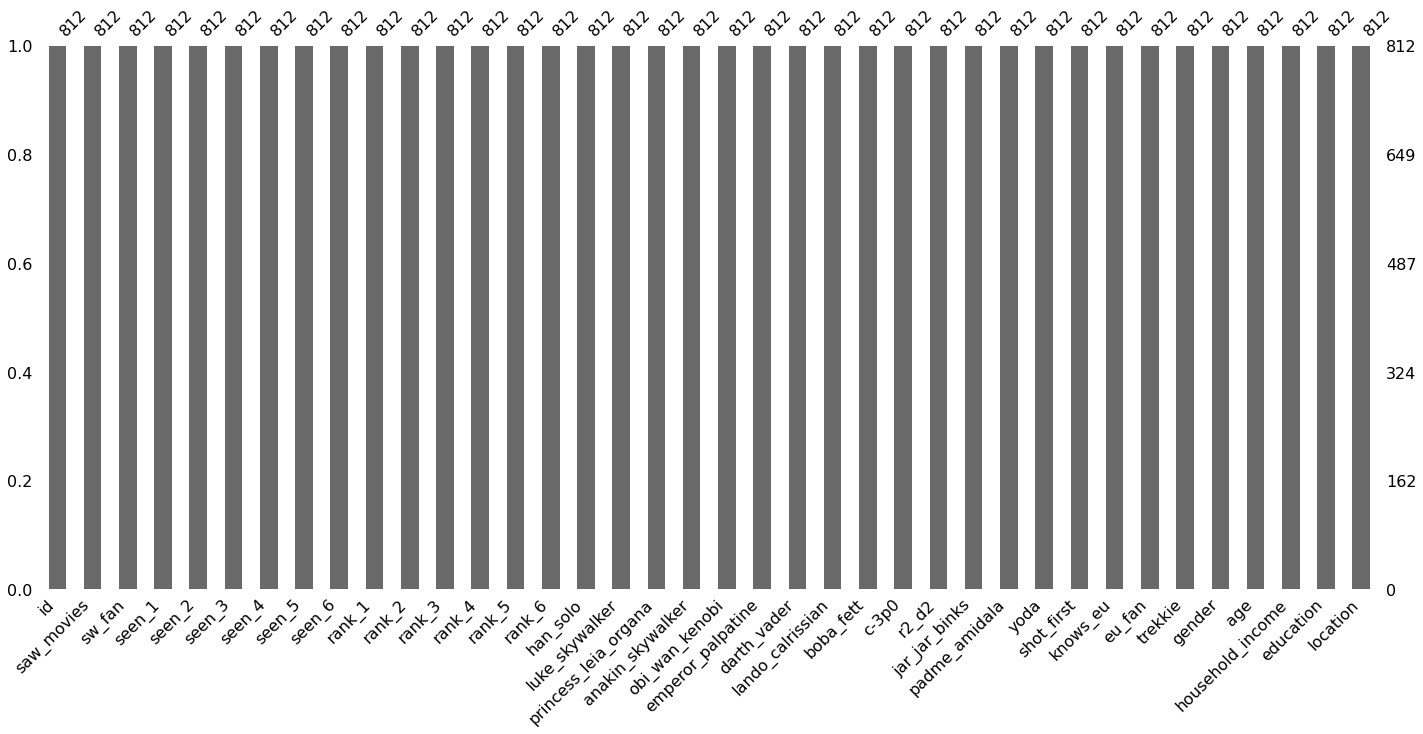

In [8]:
# I have decided to only include participants that have actually seen a 
# Star Wars movie is included in the analysis.
star_wars_up = star_wars_up[star_wars_up["saw_movies"]==True]

# For several respondends, nearly all of their inforamtion, 
# including socio-economic factors are missing, we will drop these records
star_wars_up.dropna(inplace=True,subset=["gender"])

# Whether or not a respondent is a fan of the Extended Univsere is often left out,
# only for participants who knew the EU, an anwser to this question was recorded. 
# we will therefore assume, that someone who did not know the EU is also not a fan
star_wars_up.loc[star_wars_up["knows_eu"]==False,"eu_fan"] = False

# In some cases the the charachter evaluate is NaN, we will assume that the respondents in
# these cases did not know the character and assign the respective answer
star_wars_up.loc[:,"han_solo":"yoda"] = star_wars_up.loc[:,"han_solo":"yoda"].fillna("Unfamiliar (N/A)")

# around 150 of 820 remaining respondents chose not to disclose their income,
# since this is not an important feature, we will keep and mark the missing info
star_wars_up["household_income"] = star_wars_up["household_income"].fillna("no info")

# Let's now drop a few records which still have some missing info instead of fixing them 1 by 1
star_wars_up.dropna(inplace=True)

#overview of missing values
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    msno.bar(star_wars_up)

After we cleaned and imputed values as described in the above code cell, the data now looks like it is ready for further analysis.

We have removed ca. 300 records from our analysis, but these held almost no information for our further analysis.

# Visualizing the results 

## Who knows the lore?

Whether or not Han shot first is of course up to [no debate](https://www.youtube.com/watch?v=eIn-ha98iCk). But does the casual Star Wars know the facts? What do hardcore fans think?
<br>To explore these questions I have prepared a parallel categories chart.

In [9]:
# build parallel categories plot
fandom = [
    # 'trekkie',
    'sw_fan',
    # 'knows_eu',
    'eu_fan',
    'shot_first']
parallel_cat = star_wars_up[fandom]
fig = px.parallel_categories(parallel_cat.dropna(subset=["sw_fan"]))
fig.show()

The graphs shows for example:
+ the majority of respondents who understood the question thought that Han shot first (319 of 510)
+ the majority of non-fans did not understand the question (175 out of 274), but..  
+ ... even a few self-proclaimed Star Wars fans did not understand the question (~70) and...
+ ... even more shocking: a few fans of the extended universe did not understand the question (9)

Bonus:
+ believing that Han shot first only slightly decreases his favorability among respondents.

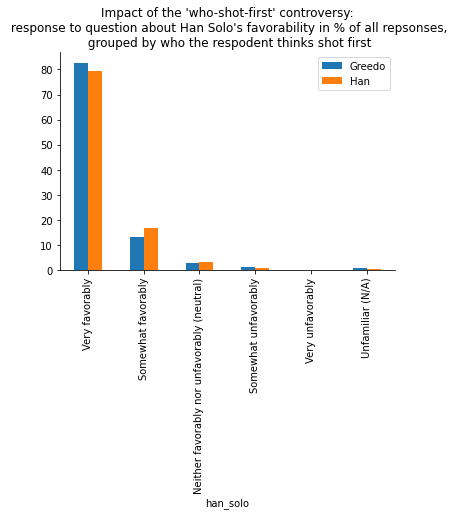

In [10]:
# plot impact of knowing that Han shot first
shot = star_wars_up[star_wars_up["shot_first"]!= "I don't understand this question"]

temp_pivot = shot.pivot_table(columns="shot_first", index="han_solo",
                              values="id", aggfunc="count", margins="true")
temp_pivot = temp_pivot.div(temp_pivot.loc["All", :])*100
temp_pivot = temp_pivot.drop(columns="All", index="All")
temp_pivot = temp_pivot.reindex(["Very favorably", "Somewhat favorably",
                                 "Neither favorably nor unfavorably (neutral)",
                                 "Somewhat unfavorably", "Very unfavorably",
                                 "Unfamiliar (N/A)"])

ax = temp_pivot.plot(kind="bar", 
                     title="Impact of the 'who-shot-first' controversy:\n response to question about Han Solo's favorability in % of all repsonses,\n grouped by who the respodent thinks shot first")
plt.legend(bbox_to_anchor=(1, 1))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

## Preparing tidy datasets to expedite plotting

To enable quicker analysis I have formatted the two main sections of the survey,
(movie rank, character evaluations) into separate melted tables - melted table for characters computed in respective section.

In [11]:
# first: grouping the columns
id_vars = ["id", "sw_fan", "knows_eu", "eu_fan", "shot_first", "trekkie", 
           "gender", "age", "household_income", "education", "location"]
movie_ranks = ["rank_1","rank_2","rank_3","rank_4","rank_5","rank_6"]


# table for movie ranks
ranks_melt = pd.melt(star_wars_up, id_vars=id_vars, var_name="movie",
                    value_vars=movie_ranks, value_name="movie_rank")
ranks_melt["movie"] = ranks_melt["movie"].str.replace("rank_","Episode ")

## Interactive plots, part 1: How do opinions on the best movies differ?

After going through several types of visualizations (including violin and histograms with "overlay"-barmode), 
I decided to make a boxplot. I used nbextension to avoid having to make many similar plots. I got the idea from this great [Medium post](https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6).

In [12]:
if True:
    color_facet_row="sw_fan"
# building interactive chart with Juypter widgets
# @interact
# def widget_histogram(color_facet_row=id_vars[1:]):
    print("Pick a respondent characteristic from the drop-down selection above. \n")
    fig = px.box(ranks_melt, # caution: px won't work with NaN-values present
                 y="movie_rank",
                 x="movie",
                 color=color_facet_row, 
                 facet_row=color_facet_row,
                 height=750,
                 title="Boxplot: ranking of Star Wars movies (1=best, 6=worst) by respondent characteristic",
                 range_y= (6.5,0.5)
                )
    print("The number of non-NaN responses for {} is:".format(color_facet_row))
    print((ranks_melt.pivot_table(columns=color_facet_row, 
                                  aggfunc="count", 
                                  values="id",
                                  #margins=True,
                                  dropna=False)/6).transpose().astype(int).rename(columns={"id":""}))

    for a in fig.layout.annotations:
        a.textangle=0

    # to change all 
    #fig.update_yaxes(title="", showgrid=False, showticklabels=False)
    fig.update_layout(legend=dict(x=1.1, y=1.3))
    fig.show()

Pick a respondent characteristic from the drop-down selection above. 

The number of non-NaN responses for sw_fan is:
           
sw_fan     
False   274
True    538


<font color='red'>**Unfortunately nbextension's widget raises errors on nbviewer and binder, so the respective code is commented out. Therefore chart no dynamic changes of chart inputs possible. See this [Medium post for examples](https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6)**</font>

Cycling through the different respondent characteristics, I noticed the following noteworthy things:
+ **sw_fan:** Non Star Wars fans rank the newer trilogy (Episode 1-3) higher than Star Wars fans do. <br> For example: At least 75% of fans rank Episode 2 fourth or lower (median = fifth). 75% of non-fans rank Episode 2 as second best film or lower (median=fourth). <br> Star Wars fans appreciate Episode 4 much more (median =second) than non-fans (median=fourth). 
+ **eu_fan:** On the aggregate, fans of the extended universe in my opinion have got ranking pretty right. Episodes 1-3 being much poorer than Episodes 4-6 with Episodes 2 being the weakest of all and Episode 5 being the best of all. 
+ **shot_first:** This questions might be a decent predictor of a person's movie taste. Participants who were unable to answer it sometimes rank Episode 5 poorly - scandalous!
+ **gender:** Females seem to enjoy Episode 1 more than males. It is the other way around for Episode 3. Episode 3 features a darker tone and is [more violent](https://youtu.be/8631ukAVr6g?t=160).
+ **age**: I found it absolutely astonishing that older people (>60 years) liked Episode 1 quite a bit.

For fun: below charts let's you explore movie ratings by two categories. 

In [13]:
if True:
    cat_1="sw_fan"
    cat_2="eu_fan"
    movie_rank ="rank_5"

# # now interactive parallel categories
# @interact
# def widget_parallel_cats(cat_1=id_vars[1:],
#                          cat_2=id_vars[2:],
#                          movie_rank=movie_ranks):

    parallel_cat = star_wars_up[[cat_1,cat_2,movie_rank]]
    fig = px.parallel_categories(parallel_cat, 
                                 color=movie_rank, 
                                 color_continuous_scale=px.colors.sequential.Inferno)
    fig.show()

<font color='red'>**Unfortunately nbextension's widget raises errors on nbviewer and binder, so the respective code is commented out. Therefore chart no dynamic changes of chart inputs possible. See this [Medium post for examples](https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6)**</font>

## Interactive plots part 2: How likeable are the characters?

In [14]:
# melted table for character evaluations
char_eval = star_wars_up.columns[15:29].to_list()

char_melt = pd.melt(star_wars_up.dropna(subset=["sw_fan"]), id_vars=id_vars, var_name="character",
                    value_vars=char_eval, value_name="char_eval")

char_melt.replace(to_replace="Neither favorably nor unfavorably (neutral)",
                   value="neutral", inplace=True)

# exclude unfamiliar from analysis
char_melt = char_melt.loc[char_melt["char_eval"]!="Unfamiliar (N/A)",:]

# merge very (un-)favorably and somewhat (un-)favorably for analysis
char_melt["char_eval"] = char_melt["char_eval"].str.lower()
char_melt.loc[:,"char_eval"] = char_melt.loc[:,"char_eval"].str.replace("very ", "")
char_melt.loc[:,"char_eval"] = char_melt.loc[:,"char_eval"].str.replace("somewhat ", "")

ranks_melt.head(2)

,id,sw_fan,knows_eu,eu_fan,shot_first,trekkie,gender,age,household_income,education,location,movie,movie_rank
0,3292879998,True,True,False,I don't understand this question,False,Male,18-29,no info,High school degree,South Atlantic,Episode 1,3.000
1,3292765271,False,False,False,I don't understand this question,False,Male,18-29,0-24k,High school degree,West North Central,Episode 1,1.000


In [15]:
if True:
    resp_char="sw_fan"
# # build interactive facet plot
# @interact
# def widget_fact(resp_char=id_vars[1:]):
    char_cats = ["favorably",
                 "neutral", 
                 "unfavorably",
                 "unfamiliar (n/a)"]
    fig = px.histogram(char_melt,
                       x="char_eval",
                       orientation="v", 
                       facet_row="character",
                       #barmode="overlay", # uncomment instead of facet-col for boolean columns gives nice chart
                       #y = resp_char, # uncomment instead of facet-col for boolean columns gives nice chart
                       facet_col = resp_char,
                       color=resp_char,
                       category_orders={"char_eval": char_cats},
                       height=1100, 
                       title='Favorability by character and respondent characteristic', 
                       histnorm="percent"
                      )

    # to change each annotation individually
    for a in fig.layout.annotations:
        a.text = a.text.replace("character=","")
        a.text = a.text.replace("_"," ")
        a.text = a.text.title()
        a.textangle=0

    # to change all 
    fig.update_yaxes(title="", showgrid=False, showticklabels=False)
    fig.update_layout(legend=dict(x=1.1, y=1.1))
    fig.show()

<font color='red'>**Unfortunately nbextension's widget raises errors on nbviewer and binder, so the respective code is commented out. Therefore chart no dynamic changes of chart inputs possible. See this [Medium post for examples](https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6)**</font>

Cycling through the different respondent characteristics, I noticed the following noteworthy things:
+ **sw_fan:** Fans really don't like poor Jar Jar (50% unfavorably - compared to 28% amongst non-fans). Emperor Palpatine splits fans into liking him or not (43% like him, 31% don't) - unlike with non-fans, who feel mostly neutral about him (53%)
+ **eu_fan**: EU-fans have a heart for villains a like Palpatine and Boba Fett (~60%) compared to only ~35-40% of non-EU-fans. 
+ **age**: Hooray: We found the Jar-Jar demographic it is 60+ years!!! More people in this age-group like him than not (39% vs. 26%). Quite the opposite of what [George Lucas intended](https://www.quora.com/Why-did-George-Lucas-want-Jar-Jar-Binks-to-be-entertaining-to-kids).


___
# Conclusion
**Note:** This was mainly a technical challenge with the aim to learn data analysis techniques and tools in Python. Please refer to "results" at the beginning of this document for an overview of insights gained from the data.

In this guided project we have applied the learnings of Step 2 of dataquest's "Data Analyst" learning path.
Additionally I explored:
+ interactive plotting with plotly and notebook widgets

It was great fun to deal with mainly categorical data and getting to know parallel categories chart and plotly express in more detail. I also believe that nbextension widgets are very hepful to explore explore a dataset. Applying the principals of [tidy data](https://vita.had.co.nz/papers/tidy-data.pdf) was also really helpful, I really like that DQ makes references to these types of core concepts.